In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import warnings
import gc
from datetime import datetime
import json
import sys
import platform
from joblib import Parallel, delayed

warnings.filterwarnings('ignore')

from sklearn.metrics import (
    f1_score, matthews_corrcoef, accuracy_score, confusion_matrix,
    precision_score, recall_score,
    balanced_accuracy_score, roc_auc_score, average_precision_score,
    make_scorer
)
import sklearn
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost
from xgboost import XGBClassifier
import lightgbm
from lightgbm import LGBMClassifier
import imblearn
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier, EasyEnsembleClassifier
from imblearn.pipeline import Pipeline as ImbPipeline

In [2]:
SEED = 42
np.random.seed(SEED)

N_JOBS_MODELS = 4  
N_JOBS_CV = 3

f1_macro_scorer = make_scorer(f1_score, average='macro', zero_division=0)      

ROOT = Path(r"C:\Computer Science\AIMLDL\log-anomaly-detection")
FEAT_PATH = ROOT / "features"

MODELS_PATH = ROOT / "models" / "ml_models"
RESULTS_PATH = ROOT / "results"

MODELS_PATH.mkdir(parents=True, exist_ok=True)
RESULTS_PATH.mkdir(parents=True, exist_ok=True)

print(f"Models will be saved to: {MODELS_PATH}")
print(f"Results will be saved to: {RESULTS_PATH}")
print(f"Classes: 2 (Binary Classification)")

LABEL_MAP = {
    0: 'normal',
    1: 'anomaly'
}

ORIGINAL_LABEL_MAP = {
    0: 'normal',
    1: 'security_anomaly',
    2: 'system_failure',
    3: 'performance_issue',
    4: 'network_anomaly',
    5: 'config_error',
    6: 'hardware_issue'
}

Models will be saved to: C:\Computer Science\AIMLDL\log-anomaly-detection\models\ml_models
Results will be saved to: C:\Computer Science\AIMLDL\log-anomaly-detection\results
Classes: 2 (Binary Classification)


In [3]:
feat_file = FEAT_PATH / "enhanced_imbalanced_features.pkl"
if not feat_file.exists():
    print(f"Error: {feat_file} not found")
    exit(1)

with open(feat_file, 'rb') as f:
    feat_data = pickle.load(f)
    dat = feat_data['hybrid_features_data']
    num_classes = feat_data.get('num_classes', 2)

split_file = FEAT_PATH / "enhanced_cross_source_splits.pkl"
if not split_file.exists():
    print(f"Error: {split_file} not found")
    exit(1)

with open(split_file, 'rb') as f:
    split_data = pickle.load(f)
    splts = split_data['splits']

optimal_config_file = ROOT / "dataset" / "normalized" / "optimal_class_config.json"
if optimal_config_file.exists():
    with open(optimal_config_file, 'r') as f:
        optimal_config = json.load(f)
else:
    optimal_config = None

optimal_config

{'num_original_classes': 7,
 'viable_classes': [0, 1],
 'recommended_classes': [0, 1],
 'num_recommended': 2,
 'overall_class_distribution': {'0': 23077,
  '1': 8923,
  '2': 0,
  '3': 0,
  '4': 0,
  '5': 0,
  '6': 0},
 'total_samples': 32000,
 'requires_smote': False,
 'requires_class_weights': True,
 'recommended_min_samples': 100,
 'timestamp': '2025-11-05 15:06:59.223356'}

In [4]:
def build_sampler_for(y):
    """
    Build appropriate sampler based on data-driven imbalance ratio.
    Returns None if data is relatively balanced.
    """
    unique, counts = np.unique(y, return_counts=True)
    if len(counts) < 2:
        return None
    
    max_c, min_c = counts.max(), counts.min()
    imb_ratio = max_c / max(1, min_c)
    
    # Skip sampling if relatively balanced
    if imb_ratio < 3:
        return None
    
    # Calculate safe k_neighbors
    k_neighbors = min(5, min_c - 1) if min_c > 1 else 1
    k_neighbors = max(1, k_neighbors)
    
    # Choose sampler by severity
    if imb_ratio > 100:
        return ADASYN(random_state=SEED, n_neighbors=k_neighbors)
    elif imb_ratio > 10:
        return BorderlineSMOTE(random_state=SEED, k_neighbors=k_neighbors)
    else:
        return SMOTE(random_state=SEED, k_neighbors=k_neighbors)


def make_pipeline_for_model(model_name, base_model, y_tr):
    """
    Create imblearn pipeline with optional scaler, sampler, and classifier.
    - Tree-based models skip scaling (not needed)
    - Balanced ensemble models skip sampling (handle internally)
    """
    # Models that don't need scaling (tree-based)
    no_scale = {'rf', 'gb', 'xgb', 'lgbm', 'balanced_bagging', 'balanced_rf', 'easy_ensemble', 'dt'}
    
    # Models that handle imbalance internally
    balanced_models = {'balanced_bagging', 'balanced_rf', 'easy_ensemble'}
    
    # Build sampler (None for balanced models or balanced data)
    sampler = None if model_name in balanced_models else build_sampler_for(y_tr)
    
    # Build pipeline steps
    steps = []
    if model_name not in no_scale:
        steps.append(('scaler', StandardScaler()))
    if sampler is not None:
        steps.append(('sampler', sampler))
    steps.append(('clf', base_model))
    
    return ImbPipeline(steps)


def validate_classes(y_tr, y_ts, min_classes=2):
    train_classes = np.unique(y_tr)
    test_classes = np.unique(y_ts)
    
    if len(train_classes) < min_classes:
        raise ValueError(
            f"Training data has only {len(train_classes)} class(es): {train_classes}. "
            f"Need at least {min_classes} for classification."
        )
    
    unseen = set(test_classes) - set(train_classes)
    if unseen:
        print(f"Warning: Test data contains classes not in training: {sorted(unseen)}")
        print(f"These will likely be misclassified.")
    
    missing = set(train_classes) - set(test_classes)
    if missing:
        print(f"Info: Test data missing classes from training: {sorted(missing)}")
    
    print(f"Train classes: {sorted(train_classes)}")
    print(f"Test classes: {sorted(test_classes)}")
    
    return train_classes, test_classes


def calculate_focal_weights(y, alpha=0.25, gamma=2.0):
    unique_classes, class_counts = np.unique(y, return_counts=True)
    total_samples = len(y)
    
    weights = {}
    for cls, count in zip(unique_classes, class_counts):
        frequency = count / total_samples
        weight = alpha * (1 - frequency) ** gamma
        weights[int(cls)] = weight
    
    weight_sum = sum(weights.values())
    weights = {k: v/weight_sum * len(weights) for k, v in weights.items()}
    
    print(f"Focal weights calculated: {weights}")
    return weights


# Removed apply_advanced_sampling - now handled inside CV pipeline


def calculate_geometric_mean(y_true, y_pred):
    unique_classes = np.unique(y_true)
    recalls = []
    
    for class_id in unique_classes:
        y_true_binary = (y_true == class_id).astype(int)
        y_pred_binary = (y_pred == class_id).astype(int)
        recall = recall_score(y_true_binary, y_pred_binary, zero_division=0)
        recalls.append(recall)
    
    if len(recalls) > 0 and all(r >= 0 for r in recalls):
        recalls = [max(r, 1e-10) for r in recalls]
        return np.prod(recalls) ** (1/len(recalls))
    return 0.0


def calculate_iba(y_true, y_pred, alpha=0.1):
    balanced_acc = balanced_accuracy_score(y_true, y_pred)
    geometric_mean = calculate_geometric_mean(y_true, y_pred)
    iba = (1 + alpha * geometric_mean) * balanced_acc
    return iba


def calc_enhanced_metrics(y_true, y_pred, y_proba=None, y_scores=None):
    metrics = {}
    
    metrics['acc'] = accuracy_score(y_true, y_pred)
    metrics['bal_acc'] = balanced_accuracy_score(y_true, y_pred)
    metrics['f1_macro'] = f1_score(y_true, y_pred, average='macro', zero_division=0)
    metrics['f1_weighted'] = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    metrics['f1_micro'] = f1_score(y_true, y_pred, average='micro', zero_division=0)
    metrics['mcc'] = matthews_corrcoef(y_true, y_pred)
    
    metrics['geometric_mean'] = calculate_geometric_mean(y_true, y_pred)
    metrics['iba'] = calculate_iba(y_true, y_pred)
    
    # Add AUROC and AUPRC for binary classification
    n_classes = len(np.unique(y_true))
    
    if y_proba is not None:
        if n_classes == 2:
            try:
                metrics['auroc'] = roc_auc_score(y_true, y_proba[:, 1])
                metrics['auprc'] = average_precision_score(y_true, y_proba[:, 1])
            except:
                metrics['auroc'] = None
                metrics['auprc'] = None
        else:
            try:
                metrics['auroc'] = roc_auc_score(y_true, y_proba, multi_class='ovr', average='macro')
            except:
                metrics['auroc'] = None
            metrics['auprc'] = None
    elif y_scores is not None and n_classes == 2:
        # Use decision scores directly for AUROC (no calibration needed)
        try:
            metrics['auroc'] = roc_auc_score(y_true, y_scores)
            metrics['auprc'] = None  # AUPRC needs probabilities
        except:
            metrics['auroc'] = None
            metrics['auprc'] = None
    else:
        metrics['auroc'] = None
        metrics['auprc'] = None
    
    per_class_metrics = {}
    unique_classes = np.unique(np.concatenate([y_true, y_pred]))
    
    for class_id in unique_classes:
        y_true_binary = (y_true == class_id).astype(int)
        y_pred_binary = (y_pred == class_id).astype(int)
        
        if y_true_binary.sum() > 0:
            per_class_metrics[int(class_id)] = {
                'precision': precision_score(y_true_binary, y_pred_binary, zero_division=0),
                'recall': recall_score(y_true_binary, y_pred_binary, zero_division=0),
                'f1': f1_score(y_true_binary, y_pred_binary, zero_division=0),
                'support': int(y_true_binary.sum()),
                'frequency': float(y_true_binary.sum() / len(y_true))
            }
    
    metrics['per_class'] = per_class_metrics
    
    # Confusion matrix with stable class order
    labels = sorted(np.unique(y_true))
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    metrics['confusion_matrix'] = cm.tolist()
    metrics['confusion_matrix_classes'] = [int(x) for x in labels]
    
    return metrics

In [5]:
mod_config = {
    'lr': {
        'model': LogisticRegression(random_state=SEED, max_iter=2000, solver='saga'),
        'p': {'clf__C': [0.1, 1.0, 10.0]},
    },
    'rf': {
        'model': RandomForestClassifier(random_state=SEED, n_jobs=N_JOBS_CV),
        'p': {'clf__n_estimators': [100, 200], 'clf__max_depth': [10, 20, None]},
    },
    'xgb': {
        'model': XGBClassifier(random_state=SEED, eval_metric='logloss', 
                              n_jobs=N_JOBS_CV, tree_method='hist'),
        'p': {'clf__n_estimators': [150, 300], 'clf__learning_rate': [0.05, 0.1], 
              'clf__max_depth': [3, 5]},
    },
    'gb': {
        'model': GradientBoostingClassifier(random_state=SEED),
        'p': {'clf__n_estimators': [100, 200], 'clf__learning_rate': [0.01, 0.1], 
              'clf__max_depth': [3, 5]},
    },
    'svm': {
        'model': SVC(random_state=SEED, probability=True, 
                    decision_function_shape='ovr', cache_size=2000),
        'p': {'clf__C': [1, 10], 'clf__kernel': ['rbf'], 'clf__gamma': ['scale', 'auto']},
    },
    'knn': {
        'model': KNeighborsClassifier(n_jobs=N_JOBS_CV),
        'p': {'clf__n_neighbors': [5, 7, 9], 'clf__weights': ['uniform', 'distance']},
    },
    'dt': {
        'model': DecisionTreeClassifier(random_state=SEED),
        'p': {'clf__max_depth': [10, 20, None], 'clf__min_samples_split': [2, 5, 10]},
    },
    'nb': {
        'model': GaussianNB(),
        'p': {'clf__var_smoothing': [1e-9, 1e-8, 1e-7]},
    },
    'lgbm': {
        'model': LGBMClassifier(random_state=SEED, n_jobs=N_JOBS_CV, verbose=-1),
        'p': {'clf__n_estimators': [150, 300], 'clf__learning_rate': [0.05, 0.1], 
              'clf__max_depth': [5, 7], 'clf__num_leaves': [31, 50]},
    },
    'balanced_bagging': {
        'model': BalancedBaggingClassifier(
            estimator=XGBClassifier(random_state=SEED, eval_metric='logloss'),
            n_estimators=50,
            random_state=SEED,
            n_jobs=N_JOBS_CV
        ),
        'p': {'clf__n_estimators': [30, 50]},
    },
    'balanced_rf': {
        'model': BalancedRandomForestClassifier(
            random_state=SEED,
            n_jobs=N_JOBS_CV
        ),
        'p': {'clf__n_estimators': [100, 200], 'clf__max_depth': [10, 20, None]},
    },
    'easy_ensemble': {
        'model': EasyEnsembleClassifier(
            n_estimators=50,
            random_state=SEED,
            n_jobs=N_JOBS_CV
        ),
        'p': {'clf__n_estimators': [30, 50]},
    }
}

In [6]:
def train_single_model(m_name, m_config, X_tr, y_tr, X_ts, y_ts, class_weights):
    """
    Train a single model using imblearn pipeline with proper CV.
    Scaling and sampling happen inside CV to prevent data leakage.
    """
    try:
        # Check CV safety
        binc = np.bincount(y_tr.astype(int))
        min_class_count = int(binc.min())
        use_cv = min_class_count >= 2 and len(m_config['p']) > 0
        n_splits = min(3, min_class_count) if use_cv else 2
        
        # Build pipeline with scaler + optional sampler + classifier
        pipe = make_pipeline_for_model(m_name, m_config['model'], y_tr)
        
        # Only apply class_weight if no sampler is used (avoid double-correction)
        sampler_in_use = 'sampler' in dict(pipe.named_steps)
        if hasattr(m_config['model'], 'class_weight') and not sampler_in_use:
            pipe.set_params(clf__class_weight=class_weights)
        
        # Train with or without CV
        if use_cv:
            cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
            grid = GridSearchCV(
                pipe,
                m_config['p'],
                cv=cv,
                scoring=f1_macro_scorer,
                n_jobs=1,
                verbose=0,
                error_score='raise'
            )
            grid.fit(X_tr, y_tr)
            best_model = grid.best_estimator_
            best_params = grid.best_params_
        else:
            best_model = pipe.fit(X_tr, y_tr)
            best_params = {}
        
        # Predict
        y_pred = best_model.predict(X_ts)
        
        # Get probabilities or decision scores for AUROC
        y_proba = None
        y_scores = None
        if hasattr(best_model, "predict_proba"):
            try:
                y_proba = best_model.predict_proba(X_ts)
            except Exception:
                pass
        elif hasattr(best_model, "decision_function"):
            try:
                y_scores = best_model.decision_function(X_ts)
            except Exception:
                pass
        
        metrics = calc_enhanced_metrics(y_ts, y_pred, y_proba, y_scores)
        
        return m_name, {
            'metrics': metrics,
            'params': best_params,
            'model': best_model
        }
        
    except Exception as e:
        print(f"Error training {m_name}: {str(e)}")
        import traceback
        traceback.print_exc()
        return m_name, {'error': str(e)}


def process_single_split(split_idx, split, feat_type_to_test):
    """Process a single cross-source split"""
    
    test_src = split['test_source']
    train_srcs = split['train_sources']
    
    print(f"\n{'='*80}")
    print(f"SPLIT {split_idx+1}/{len(splts)}: Testing on {test_src}")
    print(f"{'='*80}")
    print(f"Train sources: {', '.join(train_srcs)}\n")
    
    # Validate test source
    if test_src not in dat or dat[test_src]['labels'] is None:
        print(f"⚠️  Skipping {test_src}: No labels available")
        return None
    
    if feat_type_to_test not in dat[test_src]['feature_variants']:
        print(f"⚠️  Skipping {test_src}: Feature variant not available")
        return None
    
    # Load test data
    test_data = dat[test_src]
    X_ts = test_data['feature_variants'][feat_type_to_test]
    y_ts = test_data['labels']
    
    # Load training data
    X_tr_list, y_tr_list = [], []
    for src in train_srcs:
        if src in dat and dat[src]['labels'] is not None:
            if feat_type_to_test in dat[src]['feature_variants']:
                X_tr_list.append(dat[src]['feature_variants'][feat_type_to_test])
                y_tr_list.append(dat[src]['labels'])
    
    if not X_tr_list:
        print(f"⚠️  Skipping {test_src}: No training data available")
        return None
    
    X_tr = np.vstack(X_tr_list)
    y_tr = np.concatenate(y_tr_list)
    
    # Class validation
    print("\n--- Class Validation ---")
    try:
        train_classes, test_classes = validate_classes(y_tr, y_ts, min_classes=2)
    except ValueError as e:
        print(f"⚠️  Skipping {test_src}: {e}")
        return None
    
    # Note: Scaling and sampling now happen inside CV pipeline (no data leakage)
    print("\n--- Data Summary ---")
    print(f"Train samples: {len(y_tr):,}")
    print(f"Test samples: {len(y_ts):,}")
    print(f"Features: {X_tr.shape[1]}")
    
    # Calculate class distribution
    unique, counts = np.unique(y_tr, return_counts=True)
    imb_ratio = counts.max() / counts.min() if len(counts) > 1 else 1.0
    print(f"Train imbalance ratio: {imb_ratio:.2f}:1")
    
    # Class weight calculation (on original labels, before any sampling)
    print("\n--- Class Weight Calculation ---")
    focal_weights = calculate_focal_weights(y_tr)
    
    # Train models (scaling + sampling happen inside CV pipeline)
    print("\n" + "="*60)
    print("TRAINING MODELS (with CV pipelines)")
    print("="*60 + "\n")
    
    results = {}
    model_items = list(mod_config.items())
    
    parallel_results = Parallel(n_jobs=N_JOBS_MODELS, backend='loky', verbose=5)(
        delayed(train_single_model)(name, config, X_tr, y_tr, X_ts, y_ts, focal_weights)
        for name, config in model_items
    )
    
    for name, result in parallel_results:
        results[name] = result
        gc.collect()
    
    # Model performance summary
    print("\n--- Model Performance Summary ---")
    comparison_data = []
    
    for model_name, result in results.items():
        if 'error' not in result:
            metrics = result['metrics']
            comparison_data.append({
                'Model': model_name.upper(),
                'F1-Macro': metrics.get('f1_macro', 0),
                'F1-Weighted': metrics.get('f1_weighted', 0),
                'Balanced Acc': metrics.get('bal_acc', 0),
                'Geometric Mean': metrics.get('geometric_mean', 0),
                'IBA': metrics.get('iba', 0),
                'MCC': metrics.get('mcc', 0),
                'AUROC': metrics.get('auroc', 0) if metrics.get('auroc') else 0,
                'AUPRC': metrics.get('auprc', 0) if metrics.get('auprc') else 0
            })
        else:
            print(f"{model_name.upper()}: {result['error']}")
    
    if not comparison_data:
        print(f"⚠️  No models trained successfully for {test_src}")
        return None
    
    df_comparison = pd.DataFrame(comparison_data)
    df_comparison = df_comparison.sort_values('F1-Macro', ascending=False)
    
    print("\n" + df_comparison.to_string(index=False))
    
    best_row = df_comparison.iloc[0]
    best_model_name = best_row['Model'].lower()
    
    print(f"\n✓ Best Model: {best_model_name.upper()}")
    print(f"  F1-Macro: {best_row['F1-Macro']:.4f}")
    print(f"  Balanced Acc: {best_row['Balanced Acc']:.4f}")
    print(f"  AUROC: {best_row['AUROC']:.4f}")
    
    if best_model_name in results:
        per_class = results[best_model_name]['metrics'].get('per_class', {})
        
        print("\n--- Per-Class Performance (Best Model) ---")
        for class_id in sorted(per_class.keys()):
            class_metrics = per_class[class_id]
            class_name = LABEL_MAP.get(class_id, f'Class_{class_id}')
            print(f"{class_name} (ID {class_id}):")
            print(f"  Precision: {class_metrics['precision']:.4f}")
            print(f"  Recall:    {class_metrics['recall']:.4f}")
            print(f"  F1:        {class_metrics['f1']:.4f}")
            print(f"  Support:   {class_metrics['support']}")
    
    # Return split results
    return {
        'split_idx': split_idx,
        'test_source': test_src,
        'train_sources': train_srcs,
        'best_model': best_model_name,
        'best_metrics': {
            'f1_macro': float(best_row['F1-Macro']),
            'f1_weighted': float(best_row['F1-Weighted']),
            'balanced_acc': float(best_row['Balanced Acc']),
            'geometric_mean': float(best_row['Geometric Mean']),
            'iba': float(best_row['IBA']),
            'mcc': float(best_row['MCC']),
            'auroc': float(best_row['AUROC']),
            'auprc': float(best_row['AUPRC'])
        },
        'all_models': df_comparison.to_dict('records'),
        'results': results,
        'train_samples': int(len(y_tr)),
        'test_samples': int(len(y_ts))
    }

In [7]:
print("\n" + "="*80)
print("STARTING BINARY CLASSIFICATION PIPELINE - ALL SPLITS")
print("="*80 + "\n")

feat_type_to_test = 'selected_imbalanced'  # 200 features, optimized for imbalance
print(f"Using feature variant: {feat_type_to_test}")
print(f"Total splits to process: {len(splts)}")
print(f"Models to train per split: {len(mod_config)}")

# Process all splits
all_split_results = []

for split_idx, split in enumerate(splts):
    result = process_single_split(split_idx, split, feat_type_to_test)
    if result is not None:
        all_split_results.append(result)
    gc.collect()


STARTING BINARY CLASSIFICATION PIPELINE - ALL SPLITS

Using feature variant: selected_imbalanced
Total splits to process: 16
Models to train per split: 12

SPLIT 1/16: Testing on Android_2k
Train sources: Apache_2k, BGL_2k, Hadoop_2k, HDFS_2k, HealthApp_2k, HPC_2k, Linux_2k, Mac_2k, OpenSSH_2k, OpenStack_2k, Proxifier_2k, Spark_2k, Thunderbird_2k, Windows_2k, Zookeeper_2k


--- Class Validation ---
Train classes: [np.int32(0), np.int32(1)]
Test classes: [np.int32(0), np.int32(1)]

--- Data Summary ---
Train samples: 24,000
Test samples: 2,000
Features: 200
Train imbalance ratio: 2.48:1

--- Class Weight Calculation ---
Focal weights calculated: {0: np.float64(0.27945487501484373), 1: np.float64(1.720545124985156)}

TRAINING MODELS (with CV pipelines)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   8 out of  12 | elapsed: 16.4min remaining:  8.2min
[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed: 102.1min finished



--- Model Performance Summary ---

           Model  F1-Macro  F1-Weighted  Balanced Acc  Geometric Mean      IBA       MCC    AUROC    AUPRC
              GB  1.000000     1.000000      1.000000        1.000000 1.100000  1.000000 1.000000 1.000000
   EASY_ENSEMBLE  0.921337     0.996231      0.865385        0.854850 0.939362  0.853339 1.000000 1.000000
            LGBM  0.848485     0.993109      0.769231        0.733799 0.825677  0.731579 1.000000 1.000000
BALANCED_BAGGING  0.848485     0.993109      0.769231        0.733799 0.825677  0.731579 1.000000 1.000000
              DT  0.684980     0.986900      0.615385        0.480384 0.644947  0.477969 0.615385 0.240769
             XGB  0.658645     0.985971      0.596154        0.438529 0.622297  0.436215 0.999942 0.995773
              NB  0.563165     0.929501      0.942756        0.941016 1.031471  0.302262 0.997720 0.742857
              RF  0.496729     0.980543      0.500000        0.000010 0.500000  0.000000 0.999454 0.956777
 

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   8 out of  12 | elapsed: 12.2min remaining:  6.1min
[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed: 67.9min finished



--- Model Performance Summary ---

           Model  F1-Macro  F1-Weighted  Balanced Acc  Geometric Mean      IBA       MCC    AUROC    AUPRC
              NB  0.637945     0.722207      0.627198        0.564457 0.662600  0.304462 0.900277 0.734023
             KNN  0.414691     0.592594      0.495801        0.000010 0.495802 -0.049112 0.495801 0.285500
              RF  0.387630     0.553923      0.442967        0.000009 0.442968 -0.188296 0.404558 0.316553
     BALANCED_RF  0.264165     0.377492      0.251225        0.000007 0.251225 -0.469473 0.401731 0.319307
              DT  0.250936     0.358588      0.234430        0.000007 0.234430 -0.494353 0.234430 0.285500
BALANCED_BAGGING  0.249249     0.356177      0.232330        0.000007 0.232330 -0.497507 0.009018 0.216734
             XGB  0.249249     0.356177      0.232330        0.000007 0.232330 -0.497507 0.009108 0.215729
              GB  0.248403     0.354968      0.231281        0.000007 0.231281 -0.499088 0.009083 0.272148
 

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   8 out of  12 | elapsed: 12.7min remaining:  6.4min
[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed: 70.7min finished



--- Model Performance Summary ---

           Model  F1-Macro  F1-Weighted  Balanced Acc  Geometric Mean      IBA       MCC    AUROC    AUPRC
              GB  0.990092     0.996975      0.982143        0.981981 1.078587  0.980376 1.000000 1.000000
            LGBM  0.990092     0.996975      0.982143        0.981981 1.078587  0.980376 0.999100 0.994623
             XGB  0.986716     0.995956      0.976190        0.975900 1.071457  0.973776 1.000000 1.000000
   EASY_ENSEMBLE  0.971045     0.991293      0.949405        0.948056 1.039414  0.943687 0.999961 0.999582
              NB  0.813394     0.929914      0.955513        0.954477 1.046715  0.679996 0.995266 0.907017
             KNN  0.557946     0.877187      0.548529        0.362560 0.568416  0.125944 0.584623 0.130554
BALANCED_BAGGING  0.540908     0.888687      0.532738        0.255883 0.546370  0.245577 0.999724 0.997253
              RF  0.478079     0.875841      0.500000        0.000010 0.500000  0.000000 0.907433 0.507405
 

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   8 out of  12 | elapsed: 14.8min remaining:  7.4min
[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed: 99.0min finished



--- Model Performance Summary ---

           Model  F1-Macro  F1-Weighted  Balanced Acc  Geometric Mean      IBA       MCC    AUROC    AUPRC
             XGB  0.887712     0.894900      0.916567        0.913273 1.000275  0.796327 0.866549 0.951078
            LGBM  0.875104     0.882770      0.905653        0.901865 0.987331  0.774207 0.864672 0.948069
              LR  0.744596     0.749307      0.804353        0.781627 0.867224  0.589574 0.989252 0.993046
   EASY_ENSEMBLE  0.693995     0.694375      0.766412        0.729948 0.822356  0.531387 0.966408 0.984904
             KNN  0.659733     0.656780      0.739772        0.693574 0.791081  0.489913 0.794701 0.858595
     BALANCED_RF  0.629711     0.622938      0.718321        0.660788 0.765786  0.459328 0.796930 0.915688
BALANCED_BAGGING  0.426359     0.501581      0.440170        0.334127 0.454878 -0.134757 0.726524 0.894630
              GB  0.410574     0.511528      0.463796        0.219207 0.473963 -0.113485 0.767282 0.902819
 

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   8 out of  12 | elapsed: 13.3min remaining:  6.6min
[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed: 71.1min finished



--- Model Performance Summary ---

           Model  F1-Macro  F1-Weighted  Balanced Acc  Geometric Mean      IBA       MCC    AUROC    AUPRC
              NB  0.531168     0.948243      0.955003        0.953942 1.046104  0.229531 0.996481 0.440000
              RF  0.498621     0.991758      0.500000        0.000010 0.500000  0.000000 0.829288 0.021739
              GB  0.498621     0.991758      0.500000        0.000010 0.500000  0.000000 0.798391 0.019058
             XGB  0.498621     0.991758      0.500000        0.000010 0.500000  0.000000 0.994378 0.592041
     BALANCED_RF  0.498621     0.991758      0.500000        0.000010 0.500000  0.000000 0.770282 0.016429
              DT  0.498621     0.991758      0.500000        0.000010 0.500000  0.000000 0.500000 0.005500
   EASY_ENSEMBLE  0.498621     0.991758      0.500000        0.000010 0.500000  0.000000 0.995384 0.465134
             SVM  0.497866     0.990255      0.498492        0.000010 0.498492 -0.004079 0.975227 0.114337
 

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   8 out of  12 | elapsed:  8.2min remaining:  4.1min
[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed: 54.8min finished



--- Model Performance Summary ---

           Model  F1-Macro  F1-Weighted  Balanced Acc  Geometric Mean      IBA       MCC    AUROC    AUPRC
              LR  0.748145     0.751788      0.747075    7.454447e-01 0.802765  0.497002 0.896395 0.868258
              RF  0.356706     0.395944      0.499550    9.995494e-06 0.499550 -0.020028 0.000104 0.325763
     BALANCED_RF  0.356706     0.395944      0.499550    9.995494e-06 0.499550 -0.020028 0.237048 0.399853
             SVM  0.354005     0.392946      0.493694    9.936737e-06 0.493694 -0.075181 0.002756 0.282369
             KNN  0.344047     0.381892      0.472523    9.721343e-06 0.472523 -0.158822 0.418468 0.445000
              DT  0.277436     0.307600      0.343916    3.925101e-02 0.345266 -0.407831 0.343916 0.444013
              NB  0.255719     0.283023      0.305512    5.831941e-02 0.307293 -0.465515 0.223312 0.321826
             XGB  0.000000     0.000000      0.000000    1.000000e-10 0.000000 -1.000000 0.000000 0.334502
 

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   8 out of  12 | elapsed: 12.1min remaining:  6.0min
[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed: 87.2min finished



--- Model Performance Summary ---

           Model  F1-Macro  F1-Weighted  Balanced Acc  Geometric Mean      IBA       MCC    AUROC    AUPRC
             KNN  0.233374     0.344504      0.603023    4.630108e-01 0.630944  0.107631 0.737612 0.976144
              LR  0.188640     0.265457      0.573904    3.959311e-01 0.596627  0.087250 0.974247 0.995479
             SVM  0.044890     0.004220      0.500000    1.000000e-05 0.500000  0.000000 0.435495 0.926899
     BALANCED_RF  0.044890     0.004220      0.500000    1.000000e-05 0.500000  0.000000 0.000000 0.850752
              NB  0.036609     0.069776      0.019937    1.996850e-06 0.019937 -0.728624 0.004460 0.850094
              RF  0.027710     0.002605      0.303191    7.787060e-06 0.303192 -0.618213 0.000000 0.851117
   EASY_ENSEMBLE  0.000500     0.000047      0.005319    1.031421e-06 0.005319 -0.994406 0.000000 0.851879
             XGB  0.000000     0.000000      0.000000    1.000000e-10 0.000000 -1.000000 0.000000 0.854142
 

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   8 out of  12 | elapsed:  8.6min remaining:  4.3min
[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed: 50.5min finished



--- Model Performance Summary ---

           Model  F1-Macro  F1-Weighted  Balanced Acc  Geometric Mean      IBA       MCC    AUROC    AUPRC
              NB  0.877591     0.912467      0.919046        0.918857 1.003493  0.767931 0.973763 0.831274
              GB  0.814841     0.858252      0.902042        0.896707 0.982929  0.685929 0.986697 0.955812
   EASY_ENSEMBLE  0.787701     0.844818      0.834855        0.834855 0.904554  0.596922 0.919045 0.758600
              DT  0.780758     0.828058      0.879509        0.871533 0.956161  0.637325 0.879509 0.535242
            LGBM  0.764365     0.812930      0.868660        0.859024 0.943280  0.615270 0.997906 0.996681
             XGB  0.710220     0.760169      0.832163        0.815062 0.899990  0.547678 0.886034 0.513036
     BALANCED_RF  0.692987     0.815276      0.657591        0.568998 0.695007  0.475783 0.916799 0.739375
BALANCED_BAGGING  0.622189     0.673066      0.749933        0.726060 0.804382  0.413501 0.779112 0.356710
 

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   8 out of  12 | elapsed:  8.7min remaining:  4.4min
[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed: 54.7min finished



--- Model Performance Summary ---

           Model  F1-Macro  F1-Weighted  Balanced Acc  Geometric Mean      IBA       MCC    AUROC    AUPRC
              NB  0.979145     0.996075      0.997898        0.997896 1.097478  0.959128 1.000000 1.000000
             XGB  0.916965     0.983323      0.990541        0.990496 1.088654  0.845888 1.000000 1.000000
   EASY_ENSEMBLE  0.834869     0.963107      0.977404        0.977143 1.072910  0.711407 0.997752 0.948950
              LR  0.609908     0.859656      0.898056        0.892251 0.978185  0.399027 1.000000 1.000000
BALANCED_BAGGING  0.532338     0.789307      0.845244        0.830956 0.915480  0.312466 1.000000 1.000000
            LGBM  0.506416     0.760246      0.824750        0.805916 0.891218  0.287163 1.000000 1.000000
              DT  0.494225     0.745646      0.814766        0.793431 0.879412  0.275936 0.814766 0.120948
             SVM  0.487574     0.927853      0.500000        0.000010 0.500000  0.000000 0.998212 0.910813
 

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   8 out of  12 | elapsed:  9.0min remaining:  4.5min
[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed: 53.9min finished



--- Model Performance Summary ---

           Model  F1-Macro  F1-Weighted  Balanced Acc  Geometric Mean      IBA       MCC    AUROC    AUPRC
              GB  1.000000     1.000000      1.000000        1.000000 1.100000  1.000000 1.000000 1.000000
BALANCED_BAGGING  1.000000     1.000000      1.000000        1.000000 1.100000  1.000000 1.000000 1.000000
            LGBM  1.000000     1.000000      1.000000        1.000000 1.100000  1.000000 1.000000 1.000000
              DT  1.000000     1.000000      1.000000        1.000000 1.100000  1.000000 1.000000 1.000000
     BALANCED_RF  0.498998     0.994004      0.500000        0.000010 0.500000  0.000000 1.000000 1.000000
             XGB  0.498998     0.994004      0.500000        0.000010 0.500000  0.000000 1.000000 1.000000
              RF  0.498998     0.994004      0.500000        0.000010 0.500000  0.000000 1.000000 1.000000
             SVM  0.498998     0.994004      0.500000        0.000010 0.500000  0.000000 0.998996 0.642758
 

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   8 out of  12 | elapsed:  8.8min remaining:  4.4min
[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed: 58.1min finished



--- Model Performance Summary ---

           Model  F1-Macro  F1-Weighted  Balanced Acc  Geometric Mean      IBA      MCC    AUROC    AUPRC
              GB  1.000000     1.000000      1.000000        1.000000 1.100000 1.000000 1.000000 1.000000
             XGB  1.000000     1.000000      1.000000        1.000000 1.100000 1.000000 1.000000 1.000000
            LGBM  1.000000     1.000000      1.000000        1.000000 1.100000 1.000000 1.000000 1.000000
BALANCED_BAGGING  0.998583     0.999501      0.999723        0.999723 1.099668 0.997169 0.999972 0.999733
   EASY_ENSEMBLE  0.997172     0.999002      0.999446        0.999446 1.099335 0.994360 1.000000 1.000000
     BALANCED_RF  0.921457     0.973904      0.874359        0.865285 0.950016 0.853774 0.999778 0.997734
             SVM  0.906642     0.969282      0.853846        0.841244 0.925675 0.828268 0.999284 0.993174
              RF  0.877015     0.960277      0.815385        0.794210 0.880143 0.778828 0.999858 0.998511
          

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   8 out of  12 | elapsed:  8.9min remaining:  4.4min
[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed: 57.0min finished



--- Model Performance Summary ---

           Model  F1-Macro  F1-Weighted  Balanced Acc  Geometric Mean      IBA       MCC    AUROC    AUPRC
BALANCED_BAGGING  0.995298     0.995501      0.995622        0.995622 1.094749  0.990600 0.998296 0.994253
              LR  0.986976     0.987522      0.988787        0.988768 1.086555  0.974108 0.996901 0.990269
              GB  0.985308     0.985974      0.983612        0.983546 1.080355  0.970755 0.992385 0.987690
             XGB  0.882001     0.884270      0.903226        0.898027 0.984338  0.788888 0.997840 0.986399
            LGBM  0.879446     0.881802      0.900284        0.895294 0.980886  0.783077 0.996541 0.986777
   EASY_ENSEMBLE  0.859823     0.861859      0.884615        0.877058 0.962201  0.754093 0.994116 0.992991
              NB  0.539531     0.587409      0.574623        0.433310 0.599522  0.236077 0.949532 0.808281
     BALANCED_RF  0.398467     0.473459      0.510114        0.142224 0.517369  0.111023 0.996842 0.993038
 

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   8 out of  12 | elapsed:  9.1min remaining:  4.5min
[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed: 58.1min finished



--- Model Performance Summary ---

           Model  F1-Macro  F1-Weighted  Balanced Acc  Geometric Mean      IBA       MCC    AUROC    AUPRC
              NB  0.957875     0.967139      0.977456        0.977196 1.072973  0.919126 0.991653 0.946538
              DT  0.897872     0.925493      0.862840        0.851869 0.936343  0.814120 0.862840 0.796181
             XGB  0.675230     0.780429      0.648833        0.545587 0.684232  0.489373 0.999999 0.999996
              GB  0.544976     0.702207      0.562257        0.352865 0.582097  0.309147 1.000000 1.000000
BALANCED_BAGGING  0.533187     0.695287      0.555447        0.333009 0.573944  0.291225 0.991498 0.979205
            LGBM  0.479512     0.664044      0.526265        0.229192 0.538326  0.198905 1.000000 1.000000
   EASY_ENSEMBLE  0.437990     0.579339      0.441206        0.320639 0.455353 -0.122953 0.503045 0.421738
              RF  0.426277     0.633447      0.500000        0.000010 0.500000  0.000000 0.678891 0.390414
 

In [8]:
print("\n" + "="*80)
print("CROSS-SOURCE EVALUATION SUMMARY")
print("="*80 + "\n")

if not all_split_results:
    print("⚠️  No splits processed successfully!")
    exit(1)

# Create summary dataframe
summary_data = []
for result in all_split_results:
    summary_data.append({
        'Test Source': result['test_source'],
        'Best Model': result['best_model'].upper(),
        'F1-Macro': result['best_metrics']['f1_macro'],
        'Balanced Acc': result['best_metrics']['balanced_acc'],
        'AUROC': result['best_metrics']['auroc'],
        'AUPRC': result['best_metrics']['auprc'],
        'MCC': result['best_metrics']['mcc'],
        'Train Samples': result['train_samples'],
        'Test Samples': result['test_samples']
    })

df_summary = pd.DataFrame(summary_data)
df_summary = df_summary.sort_values('F1-Macro', ascending=False)

print("\n" + df_summary.to_string(index=False))

# Calculate aggregate statistics
print("\n" + "="*60)
print("AGGREGATE STATISTICS")
print("="*60)
print(f"\nTotal splits processed: {len(all_split_results)}/{len(splts)}")
print(f"\nAverage Performance:")
print(f"  F1-Macro:      {df_summary['F1-Macro'].mean():.4f} ± {df_summary['F1-Macro'].std():.4f}")
print(f"  Balanced Acc:  {df_summary['Balanced Acc'].mean():.4f} ± {df_summary['Balanced Acc'].std():.4f}")
print(f"  AUROC:         {df_summary['AUROC'].mean():.4f} ± {df_summary['AUROC'].std():.4f}")
print(f"  AUPRC:         {df_summary['AUPRC'].mean():.4f} ± {df_summary['AUPRC'].std():.4f}")
print(f"  MCC:           {df_summary['MCC'].mean():.4f} ± {df_summary['MCC'].std():.4f}")

print(f"\nBest performing source: {df_summary.iloc[0]['Test Source']} (F1: {df_summary.iloc[0]['F1-Macro']:.4f})")
print(f"Worst performing source: {df_summary.iloc[-1]['Test Source']} (F1: {df_summary.iloc[-1]['F1-Macro']:.4f})")

# Model frequency
model_counts = df_summary['Best Model'].value_counts()
print(f"\nBest model frequency:")
for model, count in model_counts.items():
    print(f"  {model}: {count} times ({count/len(all_split_results)*100:.1f}%)")

# Save aggregate results
aggregate_dir = RESULTS_PATH / f"aggregate_results_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
aggregate_dir.mkdir(exist_ok=True)

df_summary.to_csv(aggregate_dir / "all_splits_summary.csv", index=False)
print(f"\n✓ Aggregate results saved to: {aggregate_dir}")


CROSS-SOURCE EVALUATION SUMMARY


   Test Source       Best Model  F1-Macro  Balanced Acc    AUROC    AUPRC      MCC  Train Samples  Test Samples
    Android_2k               GB  1.000000      1.000000 1.000000 1.000000 1.000000          24000          2000
      Spark_2k               GB  1.000000      1.000000 1.000000 1.000000 1.000000          24000          2000
Thunderbird_2k               GB  1.000000      1.000000 1.000000 1.000000 1.000000          24000          2000
    Windows_2k BALANCED_BAGGING  0.995298      0.995622 0.998296 0.994253 0.990600          24000          2000
        BGL_2k               GB  0.990092      0.982143 1.000000 1.000000 0.980376          24000          2000
  Proxifier_2k               NB  0.979145      0.997898 1.000000 1.000000 0.959128          24000          2000
  Zookeeper_2k               NB  0.957875      0.977456 0.991653 0.946538 0.919126          24000          2000
     Hadoop_2k              XGB  0.887712      0.916567 0.866549 0.95

In [9]:
print("\n" + "="*80)
print("TRAINING FINAL MODEL ON ALL DATA")
print("="*80 + "\n")

# Determine best overall model
best_overall_model = model_counts.index[0].lower()
print(f"Best overall model: {best_overall_model.upper()}")

all_train_srcs = [s for s in dat.keys() if dat[s]['labels'] is not None]

X_tr_list_all, y_tr_list_all = [], []
for src in all_train_srcs:
    if feat_type_to_test in dat[src]['feature_variants']:
        X_tr_list_all.append(dat[src]['feature_variants'][feat_type_to_test])
        y_tr_list_all.append(dat[src]['labels'])

X_tr_all = np.vstack(X_tr_list_all)
y_tr_all = np.concatenate(y_tr_list_all)

print(f"Total training samples: {len(y_tr_all):,}")

# Calculate class weights on original data
focal_weights_final = calculate_focal_weights(y_tr_all)

# Build pipeline for final model
best_model_config = mod_config[best_overall_model]
final_pipe = make_pipeline_for_model(best_overall_model, best_model_config['model'], y_tr_all)

# Apply class weights if no sampler
sampler_in_use = 'sampler' in dict(final_pipe.named_steps)
if hasattr(best_model_config['model'], 'class_weight') and not sampler_in_use:
    final_pipe.set_params(clf__class_weight=focal_weights_final)

# Train with CV
if len(best_model_config['p']) > 0:
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    grid = GridSearchCV(final_pipe, best_model_config['p'], 
                       cv=cv, scoring=f1_macro_scorer, n_jobs=N_JOBS_CV, verbose=1,
                       error_score='raise')
    grid.fit(X_tr_all, y_tr_all)
    final_model = grid.best_estimator_
    final_params = grid.best_params_
    print(f"Best parameters: {final_params}")
else:
    final_model = final_pipe.fit(X_tr_all, y_tr_all)
    final_params = {}
    print(f"Model trained (no hyperparameters)")

deployment_dir = MODELS_PATH / "deployment"
deployment_dir.mkdir(exist_ok=True)

dep_data = {
    'model': final_model,  # Pipeline includes scaler/sampler/classifier
    'feature_type': feat_type_to_test,
    'model_name': best_overall_model,
    'num_classes': 2,
    'label_map': LABEL_MAP,
    'best_params': final_params,
    'focal_weights': focal_weights_final,
    'metrics': {
        'avg_f1_macro': float(df_summary['F1-Macro'].mean()),
        'avg_balanced_acc': float(df_summary['Balanced Acc'].mean()),
        'avg_auroc': float(df_summary['AUROC'].mean()),
        'avg_auprc': float(df_summary['AUPRC'].mean()),
        'avg_mcc': float(df_summary['MCC'].mean()),
        'std_f1_macro': float(df_summary['F1-Macro'].std()),
    },
    'training_samples': int(len(y_tr_all)),
    'original_samples': int(len(y_tr_all)),
    'num_splits_evaluated': len(all_split_results),
    'phase1_enhanced': True,
    'all_splits_evaluated': True,
    'timestamp': datetime.now().isoformat()
}

deployment_file = deployment_dir / "best_model_for_deployment.pkl"
with open(deployment_file, 'wb') as f:
    pickle.dump(dep_data, f)

print(f"\n✓ DEPLOYMENT MODEL SAVED:")
print(f"  Location: {deployment_file}")
print(f"  Model: {best_overall_model.upper()} (pipeline)")
print(f"  Training samples: {len(y_tr_all):,}")
print(f"  Evaluated on: {len(all_split_results)} cross-source splits")
print(f"  Average F1-Macro: {df_summary['F1-Macro'].mean():.4f}")
print(f"  Pipeline: {' -> '.join(final_model.named_steps.keys())}")


TRAINING FINAL MODEL ON ALL DATA

Best overall model: NB
Total training samples: 26,000
Focal weights calculated: {0: np.float64(0.2324961741332568), 1: np.float64(1.7675038258667433)}
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters: {'clf__var_smoothing': 1e-09}

✓ DEPLOYMENT MODEL SAVED:
  Location: C:\Computer Science\AIMLDL\log-anomaly-detection\models\ml_models\deployment\best_model_for_deployment.pkl
  Model: NB (pipeline)
  Training samples: 26,000
  Evaluated on: 13 cross-source splits
  Average F1-Macro: 0.8337
  Pipeline: scaler -> clf



GENERATING AGGREGATE VISUALIZATIONS

✓ Aggregate visualization saved to: C:\Computer Science\AIMLDL\log-anomaly-detection\results\aggregate_results_20251113_182452\aggregate_visualization.png


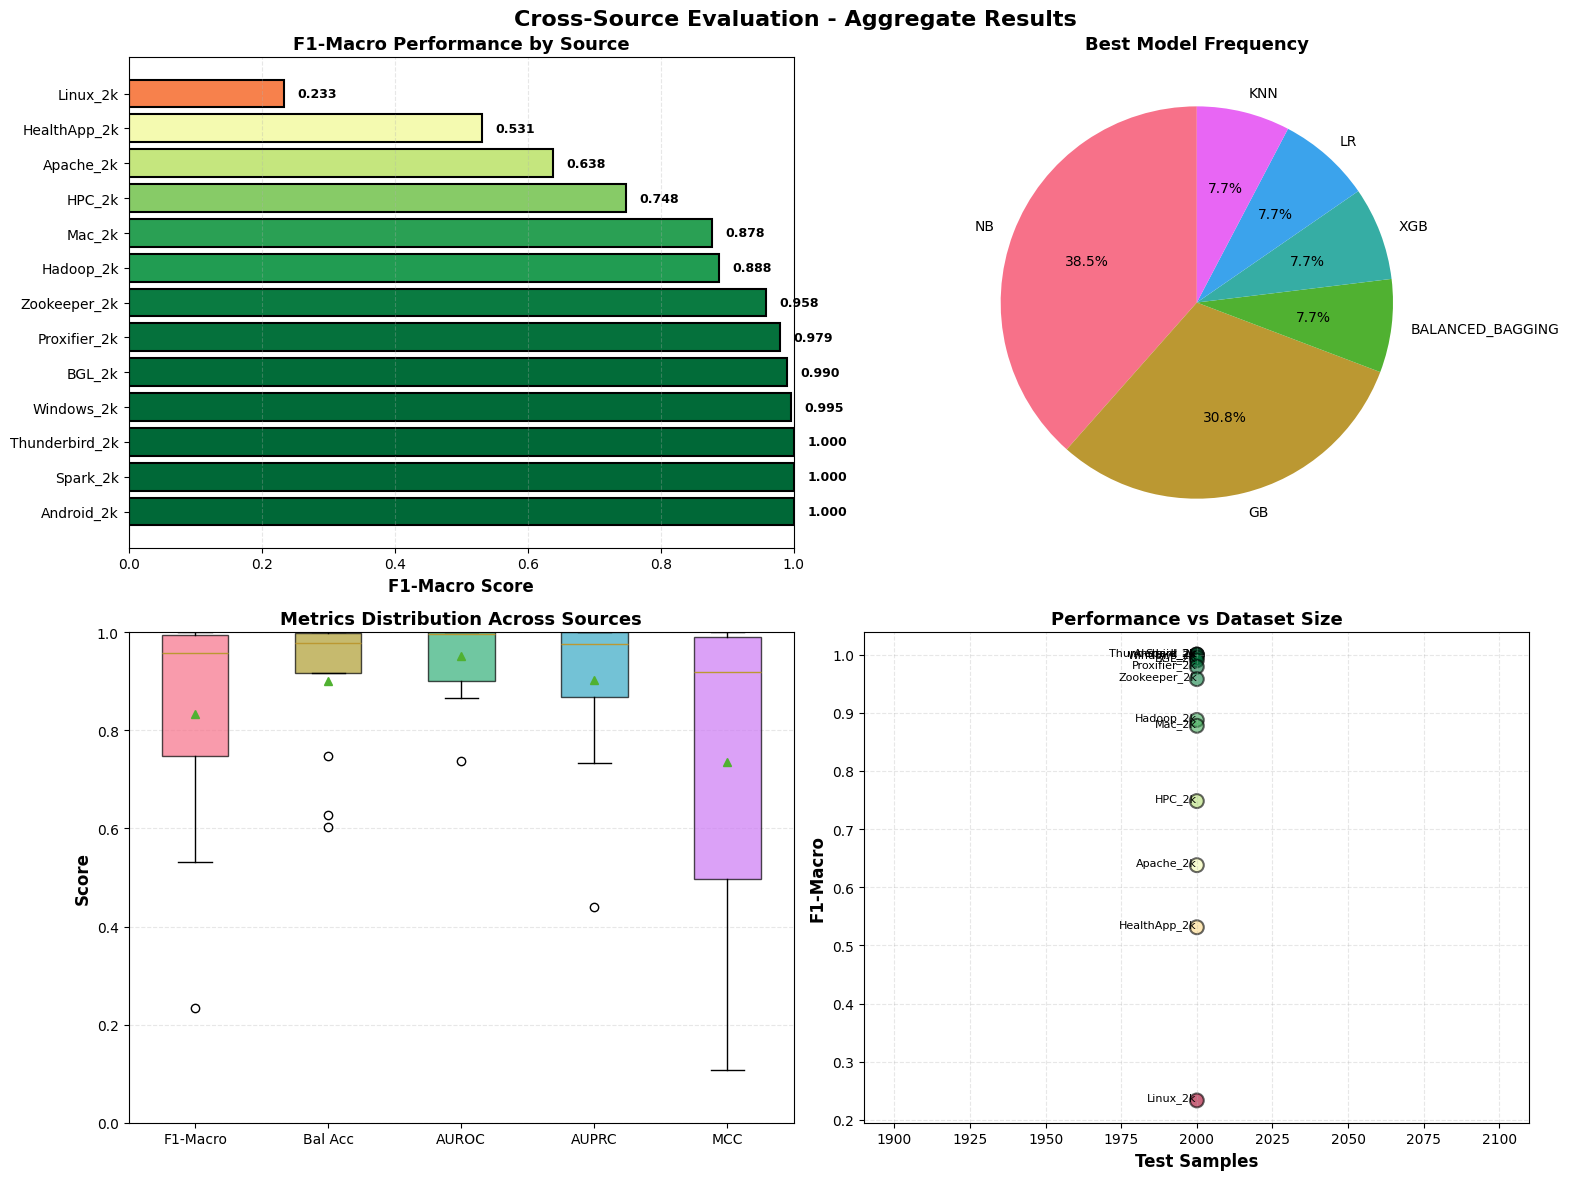

In [10]:
print("\n" + "="*80)
print("GENERATING AGGREGATE VISUALIZATIONS")
print("="*80 + "\n")

plt.style.use('default')
sns.set_palette("husl")

# Create aggregate visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Cross-Source Evaluation - Aggregate Results', fontsize=16, fontweight='bold')

# Plot 1: F1-Macro by source
ax1 = axes[0, 0]
sources = df_summary['Test Source'].values
f1_scores = df_summary['F1-Macro'].values
colors = plt.cm.RdYlGn(f1_scores)

bars = ax1.barh(sources, f1_scores, color=colors, edgecolor='black', linewidth=1.5)
ax1.set_xlabel('F1-Macro Score', fontsize=12, fontweight='bold')
ax1.set_title('F1-Macro Performance by Source', fontsize=13, fontweight='bold')
ax1.set_xlim([0, 1])
ax1.grid(axis='x', alpha=0.3, linestyle='--')

for i, (bar, score) in enumerate(zip(bars, f1_scores)):
    ax1.text(score + 0.02, bar.get_y() + bar.get_height()/2, 
            f'{score:.3f}', va='center', fontsize=9, fontweight='bold')

# Plot 2: Model frequency
ax2 = axes[0, 1]
model_freq = df_summary['Best Model'].value_counts()
ax2.pie(model_freq.values, labels=model_freq.index, autopct='%1.1f%%',
        startangle=90, colors=sns.color_palette("husl", len(model_freq)))
ax2.set_title('Best Model Frequency', fontsize=13, fontweight='bold')

# Plot 3: Metrics comparison (box plot)
ax3 = axes[1, 0]
metrics_data = df_summary[['F1-Macro', 'Balanced Acc', 'AUROC', 'AUPRC', 'MCC']].values
bp = ax3.boxplot(metrics_data, labels=['F1-Macro', 'Bal Acc', 'AUROC', 'AUPRC', 'MCC'],
                 patch_artist=True, showmeans=True)

for patch, color in zip(bp['boxes'], sns.color_palette("husl", 5)):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax3.set_ylabel('Score', fontsize=12, fontweight='bold')
ax3.set_title('Metrics Distribution Across Sources', fontsize=13, fontweight='bold')
ax3.grid(axis='y', alpha=0.3, linestyle='--')
ax3.set_ylim([0, 1])

# Plot 4: Performance vs samples
ax4 = axes[1, 1]
ax4.scatter(df_summary['Test Samples'], df_summary['F1-Macro'], 
           s=100, alpha=0.6, c=df_summary['F1-Macro'], cmap='RdYlGn',
           edgecolors='black', linewidth=1.5)

for i, source in enumerate(df_summary['Test Source']):
    ax4.annotate(source, (df_summary['Test Samples'].iloc[i], df_summary['F1-Macro'].iloc[i]),
                fontsize=8, ha='right')

ax4.set_xlabel('Test Samples', fontsize=12, fontweight='bold')
ax4.set_ylabel('F1-Macro', fontsize=12, fontweight='bold')
ax4.set_title('Performance vs Dataset Size', fontsize=13, fontweight='bold')
ax4.grid(alpha=0.3, linestyle='--')

plt.tight_layout()

viz_file = aggregate_dir / "aggregate_visualization.png"
plt.savefig(viz_file, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ Aggregate visualization saved to: {viz_file}")

plt.show()

In [11]:
results_json = {
    'experiment_info': {
        'timestamp': datetime.now().isoformat(),
        'feature_type': feat_type_to_test,
        'num_classes': 2,
        'label_map': LABEL_MAP,
        'total_splits': len(splts),
        'processed_splits': len(all_split_results)
    },
    'environment': {
        'python': sys.version.split()[0],
        'platform': platform.platform(),
        'sklearn': sklearn.__version__,
        'xgboost': xgboost.__version__,
        'lightgbm': lightgbm.__version__,
        'imblearn': imblearn.__version__,
        'numpy': np.__version__,
        'pandas': pd.__version__
    },
    'aggregate_metrics': {
        'avg_f1_macro': float(df_summary['F1-Macro'].mean()),
        'std_f1_macro': float(df_summary['F1-Macro'].std()),
        'avg_balanced_acc': float(df_summary['Balanced Acc'].mean()),
        'avg_auroc': float(df_summary['AUROC'].mean()),
        'avg_auprc': float(df_summary['AUPRC'].mean()),
        'avg_mcc': float(df_summary['MCC'].mean())
    },
    'best_model': best_overall_model,
    'model_frequency': model_counts.to_dict(),
    'per_split_results': [
        {
            'test_source': r['test_source'],
            'best_model': r['best_model'],
            'metrics': r['best_metrics']
        } for r in all_split_results
    ]
}

json_file = aggregate_dir / "aggregate_results.json"
with open(json_file, 'w') as f:
    json.dump(results_json, f, indent=2)
print(f"✓ Aggregate JSON saved to: {json_file}")

✓ Aggregate JSON saved to: C:\Computer Science\AIMLDL\log-anomaly-detection\results\aggregate_results_20251113_182452\aggregate_results.json


In [12]:
print("\n" + "="*80)
print("EXECUTION COMPLETE - ALL SPLITS EVALUATED")
print("="*80)
print(f"\n📊 Summary:")
print(f"  Splits processed: {len(all_split_results)}/{len(splts)}")
print(f"  Best overall model: {best_overall_model.upper()}")
print(f"  Average F1-Macro: {df_summary['F1-Macro'].mean():.4f} ± {df_summary['F1-Macro'].std():.4f}")
print(f"  Average Balanced Acc: {df_summary['Balanced Acc'].mean():.4f}")
print(f"  Average AUROC: {df_summary['AUROC'].mean():.4f}")
print(f"\n📁 Results saved to:")
print(f"  Aggregate: {aggregate_dir}")
print(f"  Deployment model: {deployment_file}")
print(f"\n✅ All files saved successfully!")
print("="*80 + "\n")


EXECUTION COMPLETE - ALL SPLITS EVALUATED

📊 Summary:
  Splits processed: 13/16
  Best overall model: NB
  Average F1-Macro: 0.8337 ± 0.2367
  Average Balanced Acc: 0.9016
  Average AUROC: 0.9508

📁 Results saved to:
  Aggregate: C:\Computer Science\AIMLDL\log-anomaly-detection\results\aggregate_results_20251113_182452
  Deployment model: C:\Computer Science\AIMLDL\log-anomaly-detection\models\ml_models\deployment\best_model_for_deployment.pkl

✅ All files saved successfully!

